# References

[Logistic Regression on MNIST](https://towardsdatascience.com/logistic-regression-on-mnist-with-pytorch-b048327f8d19)

# (1) Load the required packages


In [14]:
!pip install foolbox

In [15]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

import time
import torch.nn as nn
import numpy as np
from foolbox import PyTorchModel, accuracy, samples, plot, criteria, distances
import foolbox.attacks as fa
import torchvision.models as models
import eagerpy as ep
import matplotlib.pyplot as plt
import foolbox as fb

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# (2) Setup the Logistic Regression model

In [17]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_size, num_classes)
        
    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        out = self.linear(x)
        return out

# (3) Train the model

## (3a) Prepare the MNIST dataset

In [18]:
batch_size = 100

train_dataset = MNIST(root='.',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True,
                              )
test_dataset = MNIST(root='.',
                              train=False,
                              transform=transforms.ToTensor(),
                              download=True,
                              )

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                         )
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False,
                        )


## (3b) Train the model

In [19]:
input_size = 784
num_classes = 10
num_epochs = 25
lr = 0.001

In [20]:
logReg_model = LogisticRegression(input_size, num_classes).to(device)

criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(logReg_model.parameters(), lr=lr)

In [21]:
itr = 0
report_req = 100
for epoch in range(num_epochs):
    for (images, labels) in train_loader:
        images = images.reshape(-1, input_size).to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = logReg_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        if itr % report_req == 0:
            print(f'Epoch: {epoch+1}; Step: {itr+1}; Loss: {loss:.5f}')
            
        itr += 1

Epoch: 1; Step: 1; Loss: 2.27732
Epoch: 1; Step: 101; Loss: 2.20088
Epoch: 1; Step: 201; Loss: 2.06650
Epoch: 1; Step: 301; Loss: 2.00924
Epoch: 1; Step: 401; Loss: 1.89472
Epoch: 1; Step: 501; Loss: 1.88048
Epoch: 2; Step: 601; Loss: 1.78726
Epoch: 2; Step: 701; Loss: 1.71464
Epoch: 2; Step: 801; Loss: 1.63312
Epoch: 2; Step: 901; Loss: 1.58551
Epoch: 2; Step: 1001; Loss: 1.61335
Epoch: 2; Step: 1101; Loss: 1.43171
Epoch: 3; Step: 1201; Loss: 1.37884
Epoch: 3; Step: 1301; Loss: 1.40031
Epoch: 3; Step: 1401; Loss: 1.39878
Epoch: 3; Step: 1501; Loss: 1.24374
Epoch: 3; Step: 1601; Loss: 1.39727
Epoch: 3; Step: 1701; Loss: 1.22967
Epoch: 4; Step: 1801; Loss: 1.26823
Epoch: 4; Step: 1901; Loss: 1.25857
Epoch: 4; Step: 2001; Loss: 1.16621
Epoch: 4; Step: 2101; Loss: 1.17693
Epoch: 4; Step: 2201; Loss: 1.15802
Epoch: 4; Step: 2301; Loss: 1.13293
Epoch: 5; Step: 2401; Loss: 1.12106
Epoch: 5; Step: 2501; Loss: 1.04897
Epoch: 5; Step: 2601; Loss: 1.04692
Epoch: 5; Step: 2701; Loss: 1.09648
Epoc

## (3c) Test the model

In [22]:
correct = 0
total = 0
for (images, labels) in test_loader:
    images = images.reshape(-1, input_size).to(device)
    labels = labels.to(device)

    outputs = logReg_model(images)

    predicted = torch.argmax(outputs, 1)
    
    correct += torch.sum(predicted==labels)
    total += labels.shape[0]

acc = correct / total * 100
print(f'Final accuracy is: {acc:.2f}%')

Final accuracy is: 87.99%


# (4) Perform the attack

## (4a) Helper functions

In [23]:
def plot_images(images):
    fig, axs = plt.subplots(1, len(images), figsize=(24, 24))

    for i, ax in enumerate(axs.flat):
        image = images[i]
        image = np.squeeze(image, axis=0)
        ax.matshow(image)
        ax.axis('off')
        ax.set_title(f'Image {i}')

    fig.show()

## (4b) Setup the PyTorchModel and do a simple test

labels     :  [7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4]
predictions:  [7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4]
clean accuracy:  95.0 %



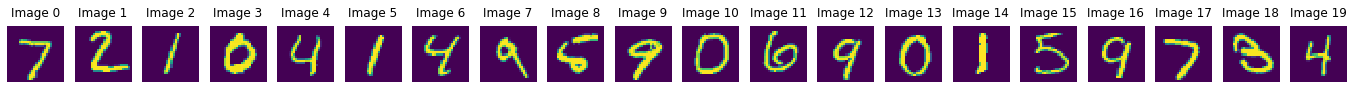

In [24]:
model = logReg_model.eval()
fmodel = PyTorchModel(model, bounds=(0, 1))
batch_size = 20
images, labels = samples(fmodel, dataset="mnist", batchsize=20)

clean_acc = accuracy(fmodel, images, labels)
predictions = fmodel(images).argmax(-1)
plot_images(images.cpu().numpy())
print("labels     : ", [l for l in labels.cpu().numpy()])
print("predictions: ", [l for l in predictions.cpu().numpy()])

print(f"clean accuracy:  {clean_acc * 100:.1f} %")
print("")

## (4c) Start the actual attack

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


{'name': 'Fast Gradient Method', 'model': L2FastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False), 'epsilons': [1, 2, 3, 4, 5]}
Clean accuracy: 0.86000
Average time taken for each test: 0.00018316411972045898 seconds
Accuracy with Fast Gradient Method attack: tensor([0.6560, 0.3400, 0.0580, 0.0070, 0.0010])
{'name': 'Fast Gradient Sign Method', 'model': LinfFastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False), 'epsilons': [0.1, 0.2, 0.3, 0.4, 0.5]}
Clean accuracy: 0.86000
Average time taken for each test: 0.0001858975887298584 seconds
Accuracy with Fast Gradient Sign Method attack: tensor([0.4230, 0.0220, 0.0000, 0.0000, 0.0000])
{'name': 'L2 Projected Gradient Descent', 'model': L2ProjectedGradientDescentAttack(rel_stepsize=0.025, abs_stepsize=None, steps=50, random_start=True), 'epsilons': [1, 2, 3, 4, 5]}
Clean accuracy: 0.86000
Average time taken for each test: 0.0021656210422515867 seconds
Accuracy with L2 Projected Gr

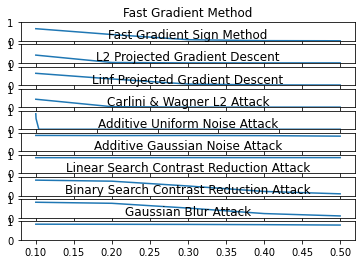

In [27]:
test_size = 1000  # assuming we are running 1000 tests for each attack
batch_size = 200   # adjust your batch size according to memory limitation, as long as it's a divisor of 1000
# test_size = 1000  # assuming we are running 1000 tests for each attack
# batch_size = 50   # adjust your batch size according to memory limitation, as long as it's a divisor of 1000
num_batch = int(test_size / batch_size)

test_dataset = MNIST(root='./data', download=True, train=False, transform=transforms.ToTensor())
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Linf_epsilons = [
    0.1,
    0.2,
    0.3,
    0.4,
    0.5
]
CW_epsilons = [
    0.1,
    1,
    10,
    100,
    1000
]
L2_epsilons = [
    1,
    2,
    3,
    4,
    5
]
attacks = [
    # gradient-based attacks
    {"name": "Fast Gradient Method", "model": fa.L2FastGradientAttack(), "epsilons": L2_epsilons},
    {"name": "Fast Gradient Sign Method", "model": fa.LinfFastGradientAttack(), "epsilons": Linf_epsilons},
    {"name": "L2 Projected Gradient Descent", "model": fa.L2ProjectedGradientDescentAttack(), "epsilons": L2_epsilons},
    {"name": "Linf Projected Gradient Descent", "model": fa.LinfProjectedGradientDescentAttack(), "epsilons": Linf_epsilons},
    {"name": "Carlini & Wagner L2 Attack", "model": fa.L2CarliniWagnerAttack(), "epsilons": CW_epsilons},
    # # decision-based attacks
    # {"name": "Boundary Attack", "model": fa.BoundaryAttack(), "epsilons": L2_epsilons}, 
    {"name": "Additive Uniform Noise Attack", "model": fa.LinfAdditiveUniformNoiseAttack(), "epsilons": Linf_epsilons},
    {"name": "Additive Gaussian Noise Attack", "model": fa.L2AdditiveGaussianNoiseAttack(), "epsilons": L2_epsilons},
    {"name": "Linear Search Contrast Reduction Attack", "model": fa.LinearSearchContrastReductionAttack(distance=distances.linf), "epsilons": Linf_epsilons}, 
    {"name": "Binary Search Contrast Reduction Attack", "model": fa.BinarySearchContrastReductionAttack(distance=distances.linf), "epsilons": Linf_epsilons}, 
    {"name": "Gaussian Blur Attack", "model": fa.GaussianBlurAttack(distance=distances.linf), "epsilons": Linf_epsilons}
]

fig, axs = plt.subplots(len(attacks))
fig.tight_layout()

attack_results = {}
for attack in attacks:
    attack_results[attack['name']] = None

for i, attack in enumerate(attacks):
    clean_accuracy = torch.zeros(num_batch)
    robust_accuracy_batch = torch.zeros([num_batch, len(L2_epsilons)])
    count = 0
    t1 = time.time()
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        if count == num_batch:
            break
        images = ep.astensor(images)
        labels = ep.astensor(labels)
        clean_accuracy[count] = fb.utils.accuracy(fmodel, images, labels)

        # The raw adversarial examples. This depends on the attack and we cannot make an guarantees about this output.
        # The clipped adversarial examples. These are guaranteed to not be perturbed more than epsilon and thus are the actual adversarial examples you want to visualize. Note that some of them might not actually switch the class. To know which samples are actually adversarial, you should look at the third tensor.
        # The third tensor contains a boolean for each sample, indicating which samples are true adversarials that are both misclassified and within the epsilon balls around the clean samples.
        raw_adv, clipped_adv, is_adv = attack["model"](fmodel, images, labels, epsilons=attack["epsilons"])

        success_ = is_adv.numpy()
        robust_accuracy_batch[count] = torch.from_numpy(1.0 - success_.mean(axis=-1))

        count += 1

    t2 = time.time()
    print(attack)
    print("Clean accuracy: {:.5f}".format(torch.mean(clean_accuracy)))
    print("Average time taken for each test: {} seconds".format((t2 - t1) / test_size))
    robust_accuracy = torch.mean(robust_accuracy_batch, dim=0)
    print("Accuracy with {} attack: {}".format(attack["name"], robust_accuracy))

    attack_results[attack['name']] = robust_accuracy

    # plot the robust accuracy against epsilons for the particular attack
    axs[i].set_ylim([0, 1])
    axs[i].plot(attack["epsilons"], robust_accuracy.numpy())
    axs[i].set_title(attack["name"])

In [28]:
attack_results

{'Additive Gaussian Noise Attack': tensor([0.8570, 0.8560, 0.8600, 0.8600, 0.8610]),
 'Additive Uniform Noise Attack': tensor([0.8650, 0.8560, 0.8610, 0.8530, 0.8250]),
 'Binary Search Contrast Reduction Attack': tensor([0.8380, 0.7810, 0.5220, 0.2240, 0.0950]),
 'Carlini & Wagner L2 Attack': tensor([0.8390, 0.5750, 0.0000, 0.0000, 0.0000]),
 'Fast Gradient Method': tensor([0.6560, 0.3400, 0.0580, 0.0070, 0.0010]),
 'Fast Gradient Sign Method': tensor([0.4230, 0.0220, 0.0000, 0.0000, 0.0000]),
 'Gaussian Blur Attack': tensor([0.8470, 0.8420, 0.8350, 0.8210, 0.8000]),
 'L2 Projected Gradient Descent': tensor([0.6350, 0.3290, 0.0520, 0.0040, 0.0000]),
 'Linear Search Contrast Reduction Attack': tensor([0.8380, 0.7810, 0.5200, 0.2240, 0.0950]),
 'Linf Projected Gradient Descent': tensor([0.4280, 0.0240, 0.0000, 0.0000, 0.0000])}